In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
import gc
from pathlib import Path


from sklearn.metrics import accuracy_score
from IPython.display import FileLink

In [ ]:
!pip freeze | grep -e fastai -e torch

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [ ]:
DATA_DIR = Path('../input')

In [ ]:
train_df = pd.read_csv(DATA_DIR/'train.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

In [ ]:
label_mapper = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

In [ ]:
train_df['label'] = train_df['label'].map(label_mapper)

In [ ]:
train_df.head()

In [ ]:
def get_ex(path): return open_image(path)

def plots_f(path, tfms, rows, cols, width, height, **kwargs):
    [get_ex(path).apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())]

In [ ]:
tfms = get_transforms(xtra_tfms=[cutout(n_holes=(1,4), length=(10, 20), p=.75), jitter(magnitude=0.005, p=.25)])
len(tfms)

In [ ]:
open_image(DATA_DIR/'images/images/7238.jpg').show()

In [ ]:
plots_f(DATA_DIR/'images/images/7238.jpg', tfms, 2, 4, 12, 6, size=150)

In [ ]:
train_il = ImageList.from_df(df=train_df, cols='image_name', path=DATA_DIR/'images/images')
test_il = ImageList.from_df(df=test_df, cols='image_name', path=DATA_DIR/'images/images')

In [ ]:
np.random.seed(0)
src1 = (train_il
        .split_from_df(col='valid')
        .label_from_df(cols='label')
        .add_test(test_il))

In [ ]:
tfms = get_transforms(xtra_tfms=[cutout(n_holes=(1,4), length=(10, 20), p=.75)])     
data1 = (src1
        .transform(tfms, size=75)
        .databunch(path='.', bs=128, num_workers=0)
        .normalize(imagenet_stats))

In [ ]:
data1

In [ ]:
data1.show_batch()

In [ ]:
learn1 = cnn_learner(data1, models.resnet50, metrics=[accuracy])

In [ ]:
learn1.lr_find()

In [ ]:
learn1.recorder.plot()

In [ ]:
rn50_stage1_callbacks = [CSVLogger(learn=learn1, filename='rn50-stage1-history'), ShowGraph(learn=learn1)]

In [ ]:
lr = (1e-2)/2
learn1.fit_one_cycle(5, slice(lr), callbacks=rn50_stage1_callbacks)

<pre>
epoch  train_loss  valid_loss  accuracy  time
0	0.779423	0.464960	0.827708	01:00
1	0.554907	0.383036	0.854124	00:58
2	0.438225	0.319695	0.888758	00:58
3	0.372599	0.299665	0.893748	00:58
4	0.349816	0.293580	0.894335	00:59
</pre>

In [ ]:
learn1.save('rn50-stage1')

In [ ]:
learn1.unfreeze()

In [ ]:
learn1.lr_find()

In [ ]:
learn1.recorder.plot()

In [ ]:
# rn101_stage2_callbacks = [CSVLogger(learn=learn1, filename='rn101-stage2-history'), EarlyStoppingCallback(learn=learn1, monitor='accuracy', min_delta=0.005, patience=8), SaveModelCallback(learn=learn1, monitor='accuracy', name='rn101-stage2'), ShowGraph(learn=learn1)]     

In [ ]:
rn50_stage2_callbacks = [CSVLogger(learn=learn1, filename='rn50-stage2-history'),ShowGraph(learn=learn1)]

In [ ]:
learn1.fit_one_cycle(5, slice(1e-5, lr/5), callbacks=rn50_stage2_callbacks)

<pre>
epoch  train_loss  valid_loss  accuracy  time
0	0.338254	0.279887	0.900205	01:01
1	0.289052	0.228289	0.918990	01:01
2	0.230371	0.223699	0.924567	01:03
3	0.176120	0.207939	0.929850	01:01
4	0.146343	0.205148	0.929557	01:02
</pre>

In [ ]:
learn1.save('rn50-stage2')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn1)

In [ ]:
interp.plot_top_losses(9)

Some of the images are mis labeled.

In [ ]:
interp.plot_confusion_matrix()

Almost all the problem is with 

mountain and glacier

street and building

In [ ]:
data2 = (src1
        .transform(tfms, size=150)
        .databunch(path='.', bs=128, num_workers=0)
        .normalize(imagenet_stats))

In [ ]:
learn1.data = data2

In [ ]:
learn1.freeze()

In [ ]:
learn1.lr_find()

In [ ]:
learn1.recorder.plot()

In [ ]:
rn50_im150_stage1_callbacks = [CSVLogger(learn=learn1, filename='rn50-im150-stage1-history'), ShowGraph(learn=learn1)]

In [ ]:
lr = (1e-2)/2
learn1.fit_one_cycle(5, slice(lr), callbacks=rn50_im150_stage1_callbacks)

<pre>
epoch  train_loss  valid_loss  accuracy  time
0	0.167107	0.178895	0.939536	01:45
1	0.173470	0.204770	0.929557	01:43
2	0.143662	0.187116	0.939536	01:42
3	0.128230	0.168570	0.945700	01:43
4	0.105784	0.167542	0.946287	01:42
</pre>

In [ ]:
learn1.save('rn50-im150-stage1');

In [ ]:
learn1.freeze()
learn1.load('rn50-im150-stage1');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn1)

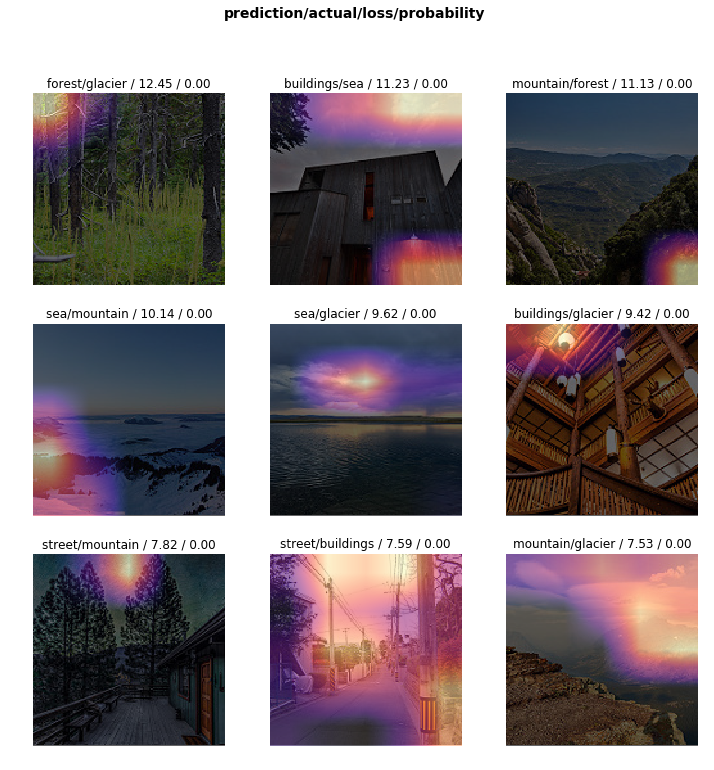

In [103]:
interp.plot_top_losses(9)

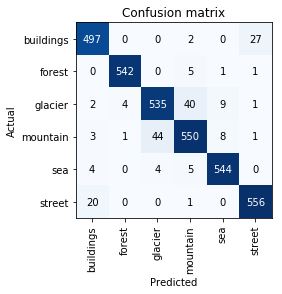

In [104]:
interp.plot_confusion_matrix()

In [105]:
val_preds_tta = learn1.TTA(ds_type=DatasetType.Valid)

In [106]:
accuracy_score(y_pred=val_preds_tta[0].argmax(1).numpy(), y_true=val_preds_tta[1].numpy())

0.9445259759319049

In [107]:
val_preds = learn1.get_preds()

In [108]:
accuracy_score(y_pred=val_preds[0].argmax(1).numpy(), y_true=val_preds[1].numpy())

0.9462870560610508

In [109]:
val_img_names = [Path(i).name for i in learn1.data.valid_ds.x.items]

In [110]:
val_probs_tta_df = pd.DataFrame(val_preds_tta[0].numpy(), columns=learn1.data.train_ds.classes)
val_probs_tta_df['image_name'] = val_img_names
val_probs_tta_df['ground_label'] = val_preds_tta[1].numpy()

In [111]:
val_probs_df = pd.DataFrame(val_preds[0].numpy(), columns=learn1.data.train_ds.classes)
val_probs_df['image_name'] = val_img_names
val_probs_df['ground_label'] = val_preds[1].numpy()

In [112]:
test_preds_tta = learn1.TTA(ds_type=DatasetType.Test)

In [113]:
test_preds = learn1.get_preds(ds_type=DatasetType.Test)

In [114]:
test_img_names = [Path(i).name for i in learn1.data.test_ds.x.items]

In [115]:
test_probs_tta_df = pd.DataFrame(test_preds_tta[0].numpy(), columns=learn1.data.train_ds.classes)
test_probs_tta_df['image_name'] = test_img_names

In [116]:
test_probs_df = pd.DataFrame(test_preds[0].numpy(), columns=learn1.data.train_ds.classes)
test_probs_df['image_name'] = test_img_names

In [117]:
test_pred_tta_df = pd.DataFrame({'image_name': test_img_names})
test_pred_tta_df['label'] = test_preds_tta[0].argmax(1).numpy()

In [118]:
test_pred_df = pd.DataFrame({'image_name': test_img_names})
test_pred_df['label'] = test_preds[0].argmax(1).numpy()

In [119]:
val_probs_tta_df.to_csv('val_probs_tta.csv', index=False)
val_probs_df.to_csv('val_probs.csv', index=False)
test_probs_tta_df.to_csv('test_probs_tta.csv', index=False)
test_probs_df.to_csv('test_probs.csv', index=False)
test_pred_tta_df.to_csv('test_pred_tta.csv', index=False)
test_pred_df.to_csv('test_pred.csv', index=False)

In [120]:
!ls

__notebook_source__.ipynb      rn50-stage1-history.csv	test_probs_tta.csv
models			       rn50-stage2-history.csv	val_probs.csv
rn32-stage2-history.csv        test_pred.csv		val_probs_tta.csv
rn34-stage1-history.csv        test_pred_tta.csv
rn50-im150-stage1-history.csv  test_probs.csv


In [121]:
!ls -lh models

total 693M
-rw-r--r-- 1 root root  88M Mar 31 08:58 rn32-stage1.pth
-rw-r--r-- 1 root root  99M Mar 31 10:23 rn50-im150-stage1.pth
-rw-r--r-- 1 root root 115M Mar 31 09:40 rn50-stage1.pth
-rw-r--r-- 1 root root 294M Mar 31 09:53 rn50-stage2.pth
-rw-r--r-- 1 root root  99M Mar 31 10:40 tmp.pth


In [122]:
FileLink('val_probs_tta.csv')

/kaggle/working/val_probs_tta.csv

In [123]:
FileLink('val_probs.csv')

/kaggle/working/val_probs.csv

In [124]:
FileLink('test_probs_tta.csv')

/kaggle/working/test_probs_tta.csv

In [125]:
FileLink('test_probs.csv')

/kaggle/working/test_probs.csv

In [126]:
FileLink('test_pred_tta.csv')

/kaggle/working/test_pred_tta.csv

In [127]:
FileLink('test_pred.csv')

/kaggle/working/test_pred.csv

In [128]:
FileLink('rn50-stage1-history.csv')

/kaggle/working/rn50-stage1-history.csv

In [129]:
FileLink('rn50-stage2-history.csv')

/kaggle/working/rn50-stage2-history.csv

In [130]:
FileLink('rn50-im150-stage1-history.csv')

/kaggle/working/rn50-im150-stage1-history.csv

In [131]:
#FileLink('rn50-im150-stage2-history.csv')